In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import floor
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns',None)

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.isnull().sum()/len(df)

customerID          0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Feature Engineering

## Drop Useless&Overlap Features

In [4]:
df.drop('customerID',axis=1,inplace=True)

In [5]:
df.drop('PhoneService',axis=1,inplace=True)

## Transforming & Creating New Features

In [6]:
df['TotalCharges'] =df.apply(lambda x: float(x.TotalCharges) if '.' in x.TotalCharges else 0.0,axis=1)
df['SeniorCitizen'] =df.apply(lambda x: str(x.SeniorCitizen),axis=1)

In [7]:
df['TotalChargeTimes'] = df['TotalCharges']/df['MonthlyCharges']

# EDA

In [8]:
df['Is_Churn'] = df.apply(lambda x: 1 if x['Churn'] == 'Yes' else 0, axis=1)

In [9]:
df['Is_Churn'].mean()

0.2653698707936959

Unbalanced Data

## Categorical Features Correlation

In [10]:
column_cat = [i for i in df.columns if str(df[i].dtype)=='object' and i != 'Churn']

In [11]:
column_cat

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

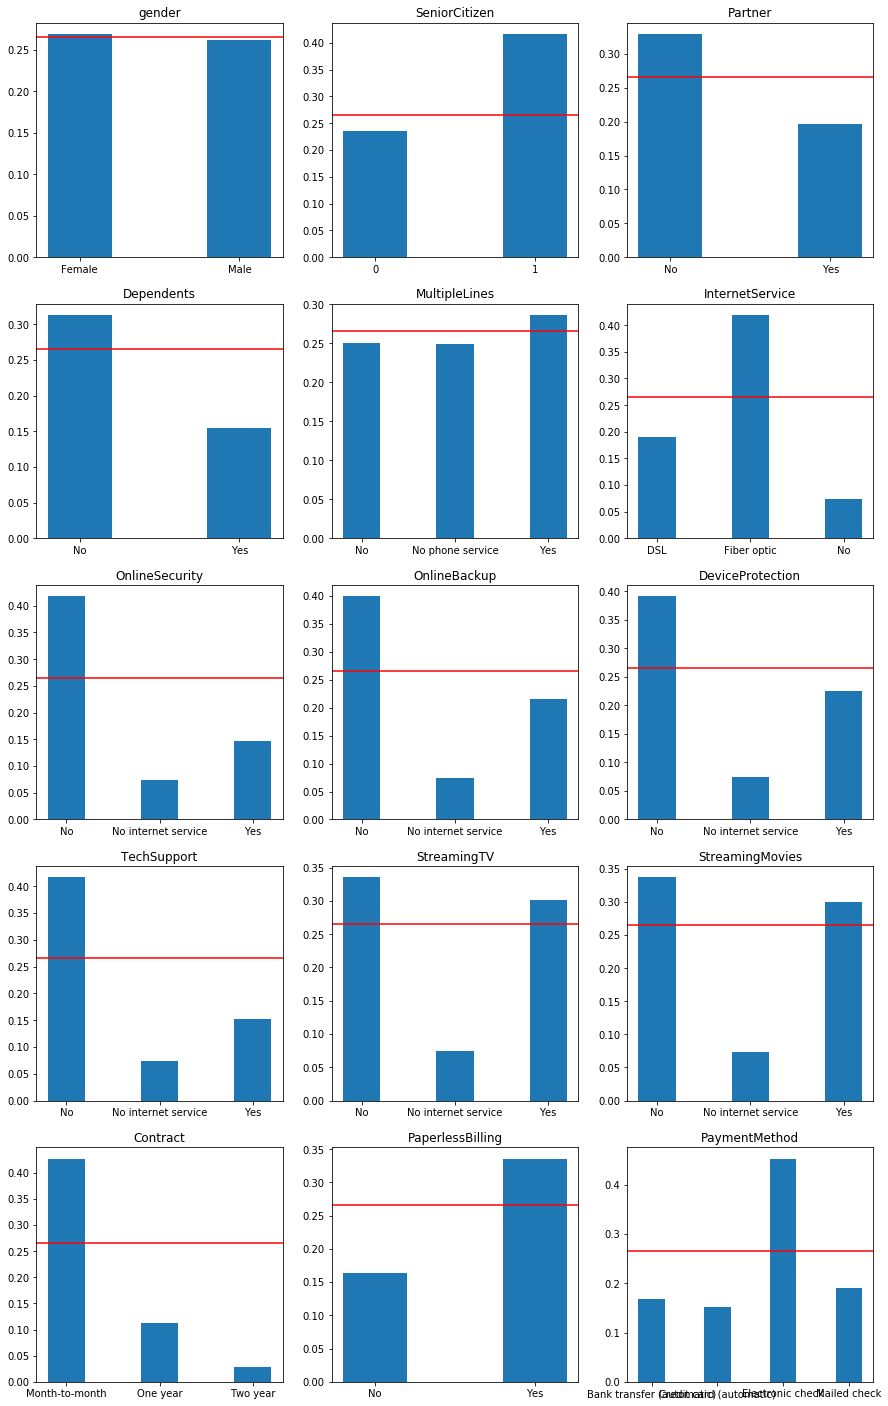

In [12]:
fig, axs = plt.subplots(5,3,figsize=(15,25))
for i,x in enumerate(column_cat):
    axs[floor(i/3)][i%3].bar(df.groupby(x)['Is_Churn'].mean().index,df.groupby(x)['Is_Churn'].mean().values,width=0.4)
    axs[floor(i/3)][i%3].axhline(df['Is_Churn'].mean(), 0, 1,c='r')
    axs[floor(i/3)][i%3].set_title(x)

<ul>
    <li>Gender and MultipleLines seem not to be useful, with similar churn situation among values</li>
    <li>For those with internet services, customers with fewer function are more likely to churn</li>
    <li>Streaming service contribute to retain custmers</li>
    <li>Month-to-month contract, PaperlessBilling and electronic payment method seem to be significant habits of high-liquidity customers, embracing flexiable services may represent their interests for more choices.</li>
</ul>

## Numerical Features Correlation

In [13]:
column_num = [i for i in df.columns if str(df[i].dtype)!='object'][:-1]

In [14]:
column_num

['tenure', 'MonthlyCharges', 'TotalCharges', 'TotalChargeTimes']

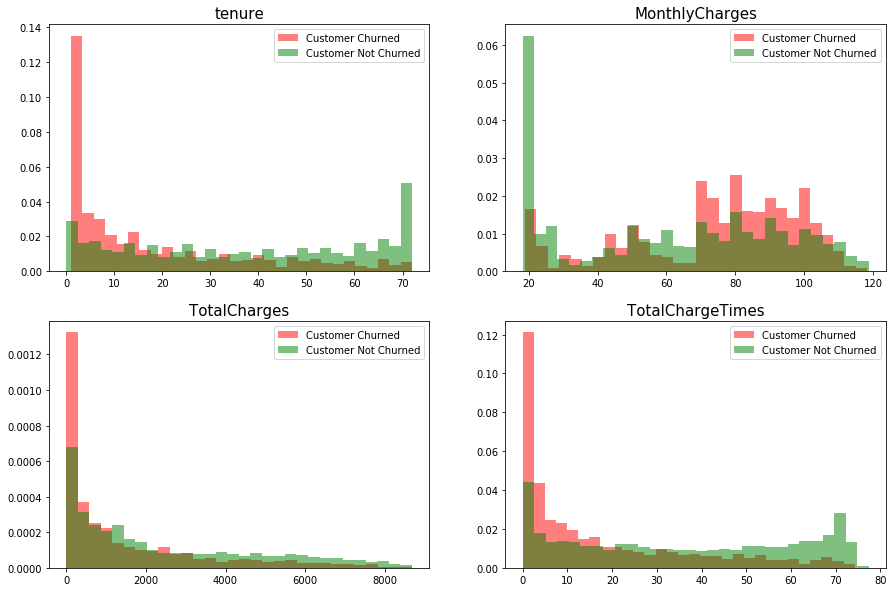

In [15]:
fig,axs = plt.subplots(2,2,figsize=(15,10))
for i,x in enumerate(column_num):
    axs[floor(i/2)][i%2].hist(df[df['Is_Churn']==1][x],bins=30,color='r',label = ['Customer Churned'],alpha=0.5,density=True)
    axs[floor(i/2)][i%2].hist(df[df['Is_Churn']==0][x],bins=30,color='g',label = 'Customer Not Churned',alpha=0.5,density=True)
    axs[floor(i/2)][i%2].set_title(x,fontsize=15)
    axs[floor(i/2)][i%2].legend(loc='best')

<ul>
    <li>Gereally,slight difference in distributions of numerical features between customer churn results</li>
    <li>Low charge times suggest higher possibility to churn, and vice versa</li>
    <li>High tenure may suggest customers willingness to stay</li>
    <li>High monthy charges are correlated with high possibility to churn, a little bit strange.</li>
    
</ul>

## Correlation Among Featrues

In [16]:
from sklearn.preprocessing import LabelEncoder

In [17]:
df_corr = df.copy()
le = LabelEncoder()
for i in column_cat:
    df_corr[i] = le.fit_transform(df_corr[i])

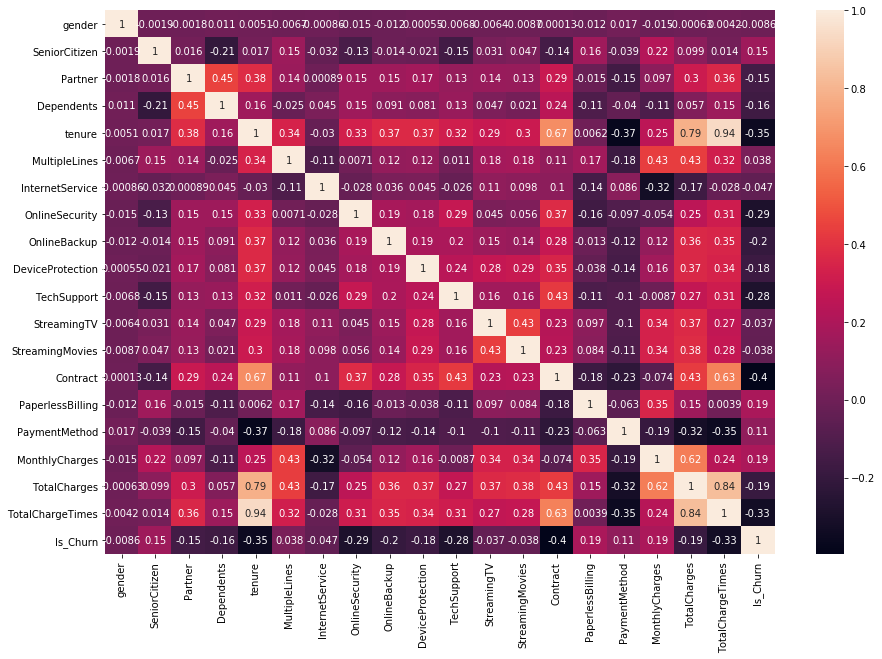

In [18]:
plt.figure(figsize=(15,10))
sns.heatmap(df_corr.corr(),annot=True)

In [19]:
del df_corr

<ul><li>TotalChargeTimes,TotalCharges is highly correlated with tenure</li>
<li>Contract is correlated with tenure</li></ul>

## Dummy Variables

In [20]:
for i in column_cat:
    column_dummy = pd.get_dummies(df[i],prefix=i)
    df = df.join(column_dummy)
    df.drop(i,inplace=True,axis=1)

In [21]:
df.head()

,tenure,MonthlyCharges,TotalCharges,Churn,TotalChargeTimes,Is_Churn,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,No,1.000000,0,1,0,1,0,0,1,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
1,34,56.95,1889.50,No,33.178227,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1
2,2,53.85,108.15,Yes,2.008357,1,0,1,1,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
3,45,42.30,1840.75,No,43.516548,0,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0
4,2,70.70,151.65,Yes,2.144979,1,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0


# Modeling

In [22]:
df.drop('Is_Churn',axis=1,inplace=True)

In [23]:
from sklearn.model_selection import KFold,train_test_split,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVC

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

from sklearn.metrics import roc_auc_score

In [24]:
y = df['Churn'].apply(lambda x: 1 if x=='Yes' else 0)
df.drop('Churn',inplace=True,axis=1)
x = df

In [25]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20)

In [26]:
kfolds = KFold(n_splits=5)

In [27]:
def model_score(model,x_train,y_train,model_param=None):
    if model_param:
        model_best = GridSearchCV(model,model_param,cv=kfolds)
        model_best.fit(x_train,y_train)
        print('Accuracy on training set:',model_best.best_estimator_.score(x_train,y_train))
        print('Accuracy on testing set:',model_best.best_estimator_.score(x_test,y_test))
        print('AUC:',roc_auc_score(y_test,model_best.best_estimator_.predict(x_test)))
        return model_best.best_estimator_
    else:
        model_best = model
        model_best.fit(x_train,y_train)
        print('Accuracy on training set:',model_best.score(x_train,y_train))
        print('Accuracy on testing set:',model_best.score(x_test,y_test))
        print('AUC:',roc_auc_score(y_test,model_best.predict(x_test)))
        return model_best

## KNN

In [28]:
KNN_param = {'n_neighbors':[3,5,7,9],'p':[1,2]}
KNN_best = model_score(KNeighborsClassifier(),x_train,y_train,KNN_param)

Accuracy on training set: 0.8148739794107206
Accuracy on testing set: 0.7906316536550745
AUC: 0.6845506547919482


## LogisticRegression

In [29]:
logistic_param = {'C':[0.001,0.01,0.1,1],'penalty':['l2','l1']}
logistic_best = model_score(LogisticRegression(solver='saga'),x_train,y_train,logistic_param)

Accuracy on training set: 0.7705005324813632
Accuracy on testing set: 0.7828246983676366
AUC: 0.6958636578257542


## Ensemble

### XGBoost

In [30]:
xgb_param = {'learning_rate':[0.001,0.01,0.1],'max_depth':[2,3,4]}
xgb_best = model_score(XGBClassifier(),x_train,y_train,xgb_param)

Accuracy on training set: 0.8205537806176784
Accuracy on testing set: 0.8161816891412349
AUC: 0.7267227296656301


### AdaBoost

In [31]:
adb_param = {'n_estimators':[30,40,60,80]}
adb_best = model_score(AdaBoostClassifier(),x_train,y_train,adb_param)

Accuracy on training set: 0.8107916222932198
Accuracy on testing set: 0.8112136266855926
AUC: 0.7243971735130823


### RandomForest

In [32]:
rf_param = {'n_estimators':[80,100,120],'max_depth':[2,3,4]}
rf_best = model_score(RandomForestClassifier(),x_train,y_train,rf_param)

Accuracy on training set: 0.792332268370607
Accuracy on testing set: 0.8168914123491838
AUC: 0.6932396055509424


## Naive Bayers

### GaussianNB

In [33]:
GaussianNB_best = model_score(GaussianNB(),x_train,y_train)

Accuracy on training set: 0.7044728434504792
Accuracy on testing set: 0.7054648687012065
AUC: 0.7483474169231019


### MultinomialNB

In [34]:
MultinomialNB_best = model_score(MultinomialNB(),x_train,y_train)

Accuracy on training set: 0.6798012069577565
Accuracy on testing set: 0.6650106458481192
AUC: 0.7021090107838508


### BernoulliNB

In [35]:
BernoulliNB_best = model_score(BernoulliNB(),x_train,y_train)

Accuracy on training set: 0.7177848775292864
Accuracy on testing set: 0.7182398864442867
AUC: 0.7403300824392017


## QDA

In [36]:
QDA_best = model_score(QDA(),x_train,y_train)

Accuracy on training set: 0.7353567625133121
Accuracy on testing set: 0.7338537970191625
AUC: 0.7574786846632693


C:\Users\Hanyu Zou\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


## GaussianProcessClassfier

In [37]:
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
GPR_param = {'kernel':['1.0 * RBF(1.0)',DotProduct(),WhiteKernel(),DotProduct()+WhiteKernel()]}
GPR_best = model_score(GaussianProcessClassifier(),x_train,y_train)

Accuracy on training set: 0.9907703230386936
Accuracy on testing set: 0.730305180979418
AUC: 0.6522927215790988


## Oversampling for Unbalanced Data

In [38]:
from imblearn.over_sampling import SMOTE

In [39]:
sm = SMOTE(random_state=53)
x_res,y_res = sm.fit_resample(x_train,y_train)

### LogisticRegression

In [40]:
logistic_param = {'C':[0.001,0.01,0.1,1],'penalty':['l2','l1']}
logistic_best_res = model_score(LogisticRegression(solver='saga'),x_res,y_res,logistic_param)

Accuracy on training set: 0.7228842412451362
Accuracy on testing set: 0.6671398154719659
AUC: 0.7248639129042587


### QDA

In [41]:
QDA_best_res = model_score(QDA(),x_res,y_res)

Accuracy on training set: 0.8000972762645915
Accuracy on testing set: 0.7537260468417317
AUC: 0.5


C:\Users\Hanyu Zou\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


### Naive Bayers

#### MultinomialNB

In [42]:
MultinomialNB_best_res = model_score(MultinomialNB(),x_res,y_res)

Accuracy on training set: 0.708171206225681
Accuracy on testing set: 0.6713981547196594
AUC: 0.706346298919444


#### GaussianNB

In [43]:
GaussianNB_best_res = model_score(GaussianNB(),x_res,y_res)

Accuracy on training set: 0.7850194552529183
Accuracy on testing set: 0.7310149041873669
AUC: 0.7429839843262399


#### BernoulliNB

In [44]:
BernoulliNB_best_res = model_score(BernoulliNB(),x_res,y_res)

Accuracy on training set: 0.7799124513618677
Accuracy on testing set: 0.7224982256919801
AUC: 0.7383043792094736


### Ensemble

#### AdaBoost

In [45]:
adb_param = {'n_estimators':[30,40,60,80]}
adb_best_res = model_score(AdaBoostClassifier(),x_res,y_res,adb_param)

Accuracy on training set: 0.8560311284046692
Accuracy on testing set: 0.7977288857345636
AUC: 0.7397045973830031


#### XGBoost

In [46]:
xgb_param = {'learning_rate':[0.001,0.01,0.1],'max_depth':[2,3,4]}
xgb_best_res = model_score(XGBClassifier(),x_res,y_res,xgb_param)

Accuracy on training set: 0.8809581712062257
Accuracy on testing set: 0.7991483321504613
AUC: 0.7309450929951101


# Conclusion

In [49]:
models = ['LogisticRegression','QDA','GaussianNB','BernoulliNB','MultinomialNB','AdaBoost','XGBoost']
result = pd.DataFrame({'Before Oversampling':[roc_auc_score(y_test,logistic_best.predict(x_test)),
                                              roc_auc_score(y_test,QDA_best.predict(x_test)),
                                              roc_auc_score(y_test,GaussianNB_best.predict(x_test)),
                                              roc_auc_score(y_test,BernoulliNB_best.predict(x_test)),
                                              roc_auc_score(y_test,MultinomialNB_best.predict(x_test)),
                                              roc_auc_score(y_test,adb_best.predict(x_test)),
                                              roc_auc_score(y_test,xgb_best.predict(x_test))],
                       'After Oversampling':[roc_auc_score(y_test,logistic_best_res.predict(x_test)),
                                              roc_auc_score(y_test,QDA_best_res.predict(x_test)),
                                              roc_auc_score(y_test,GaussianNB_best_res.predict(x_test)),
                                              roc_auc_score(y_test,BernoulliNB_best_res.predict(x_test)),
                                              roc_auc_score(y_test,MultinomialNB_best_res.predict(x_test)),
                                              roc_auc_score(y_test,adb_best_res.predict(x_test)),
                                              roc_auc_score(y_test,xgb_best_res.predict(x_test))]})
result.rename(index={i:x for i,x in enumerate(models)})

,Before Oversampling,After Oversampling
LogisticRegression,0.695864,0.724864
QDA,0.757479,0.500000
GaussianNB,0.748347,0.742984
BernoulliNB,0.740330,0.738304
MultinomialNB,0.702109,0.706346
AdaBoost,0.724397,0.739705
XGBoost,0.726723,0.730945


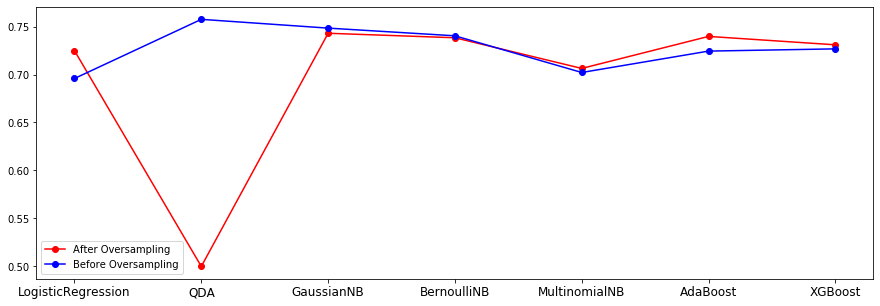

In [50]:
fig = plt.figure(figsize=(15,5))
plt.rc('xtick',labelsize=12)
plt.plot(models,result['After Oversampling'],label='After Oversampling',color='r',marker = 'o')
plt.plot(models,result['Before Oversampling'],label='Before Oversampling',color='b',marker = 'o')
plt.legend()

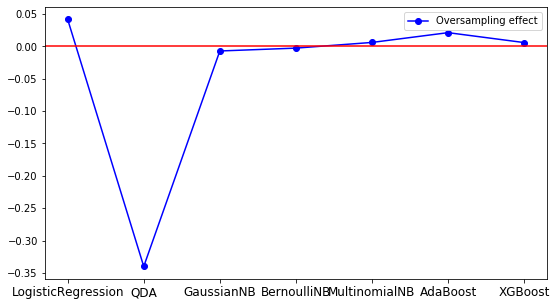

In [51]:
fig = plt.figure(figsize=(9,5))
plt.rc('xtick',labelsize=12)
plt.plot(models,result['After Oversampling']/result['Before Oversampling']-1,label='Oversampling effect',color='b',marker = 'o')
plt.axhline(0, 0, 1,c='r',)
plt.legend()

<ul><li>Oversampling lifted the AUC of most models slightly</li>
    <li>Oversampling had little effect on generative models</li>
    <li>Oversampling made the performance of QDA much worse, possibly due to existing overfitting</li></ul>